# ***Table of Contents***

1. **Import Libraries**
2. **Data Preparation**

   - 2.1 - **Load Dataset**
   - 2.2 - **Understand the Data**
   - 2.3 - **Checking information about the data**
   - 2.4 - **Visualizing/Exploring the data**
   - 2.5 - **Missing/Duplicate/Null Value Treatment**
   - 
3. **Removing irrelevant data**
4. **Dropping unnecesasry rows**
5. **Preprocess the Text Data**
6. **Handle class imbalance**
7. **Splitting the data into Train and Test**
8. **Vectorize Text Data (TF-IDF Transformation)**
9. **Cross Validation**
10. **Hyperparameter Tuning with GridSearchCV**
11. **Train Logistic Regression model with class weights**
12. **Evaluating the Model**
13. **Using TF-IDF for Random Forest**
14. **Importing the test dataset**
15. **Transform the test data using the trained TF-IDF vectorizer**
16. **Evaluate predictions**

In [1]:
# Step 1: Import Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import re

#Getting rid of warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Step 2: Data Preparation

#  2.1 : Load Dataset

df=pd.read_csv(r'C:\Users\Optimus\Desktop\Hackathon Data Science\train_product_data.csv')
df.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,Clothing,SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,Footwear,SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."


In [3]:
# 2.2 : Understanding the data

df.shape

(14999, 15)

In [4]:
# 2.3 : Checking information about the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  14999 non-null  object 
 1   crawl_timestamp          14999 non-null  object 
 2   product_url              14999 non-null  object 
 3   product_name             14999 non-null  object 
 4   product_category_tree    14999 non-null  object 
 5   pid                      14999 non-null  object 
 6   retail_price             14942 non-null  float64
 7   discounted_price         14942 non-null  float64
 8   image                    14996 non-null  object 
 9   is_FK_Advantage_product  14999 non-null  bool   
 10  description              14998 non-null  object 
 11  product_rating           14999 non-null  object 
 12  overall_rating           14999 non-null  object 
 13  brand                    10289 non-null  object 
 14  product_specifications

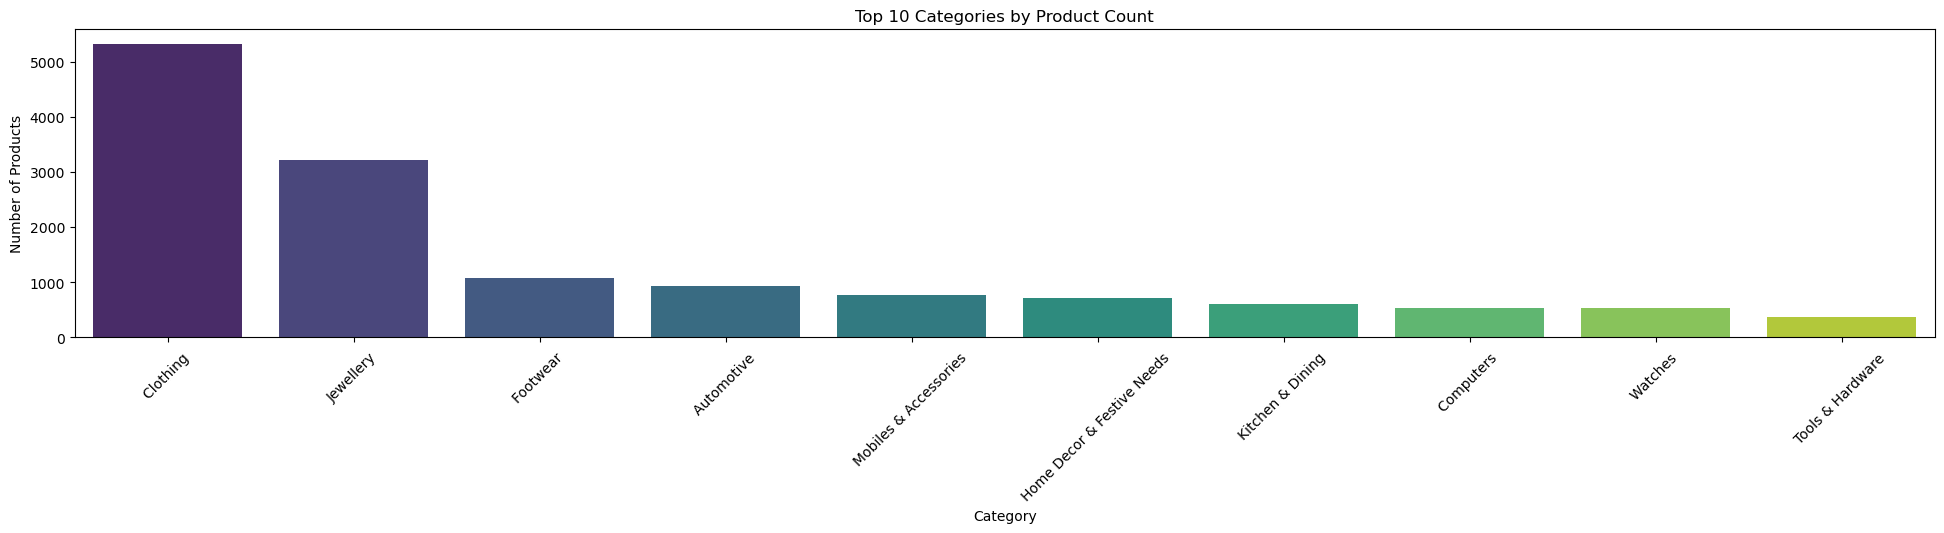

In [5]:
# 2.4 : Visualizing/Exploring the data

category_counts = df['product_category_tree'].value_counts()
plt.figure(figsize=(24, 4))
sns.barplot(x=category_counts.index[:10], y=category_counts.values[:10], palette='viridis')
plt.title('Top 10 Categories by Product Count')
plt.xlabel('Category')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)  # Rotate category labels for better readability
plt.show()

In [6]:
# 2.5: Checking null values

df.isna().sum()

uniq_id                       0
crawl_timestamp               0
product_url                   0
product_name                  0
product_category_tree         0
pid                           0
retail_price                 57
discounted_price             57
image                         3
is_FK_Advantage_product       0
description                   1
product_rating                0
overall_rating                0
brand                      4710
product_specifications        6
dtype: int64

In [7]:
# 2.5: Checking Duplicate values   

df.duplicated().sum()

0

In [8]:
# Step 3: Removing irrelevant data

df = df.dropna(subset = ['description']).reset_index(drop = True)
df = df[['description', 'product_category_tree']].copy()
df.head()

,description,product_category_tree
0,Key Features of Alisha Solid Women's Cycling S...,Clothing
1,Key Features of AW Bellies Sandals Wedges Heel...,Footwear
2,Key Features of Alisha Solid Women's Cycling S...,Clothing
3,Key Features of Alisha Solid Women's Cycling S...,Clothing
4,"Key Features of dilli bazaaar Bellies, Corpora...",Footwear


In [9]:
# Step 4: Dropping 1 row in Discription column where the Value is NaN

df.dropna(subset=['description'],inplace=True)

In [10]:
# Step 5: Preprocess the Text Data

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers

df['cleaned_description'] = df['description'].apply(preprocess_text)

In [11]:
# Step 6: Handle class imbalance

unique_classes = df['product_category_tree'].unique()
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=df['product_category_tree'])

class_weight_dict = dict(zip(unique_classes, class_weights))

In [12]:
# Step 7: Splitting the data into Train and Test

x=df['description']
y=df['product_category_tree']

x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.80,random_state=42)

In [13]:
# Step 8: Vectorize Text Data (TF-IDF Transformation)

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

In [14]:
# Step 9: Cross Validation

model = LogisticRegression()

# Perform 5-fold cross-validation

cv_scores = cross_val_score(model, x_train_tfidf, y_train, cv=5, scoring='accuracy')

# Display cross-validation scores and mean accuracy

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation accuracy:", cv_scores.mean())

Cross-validation scores: [0.97208333 0.97208333 0.96791667 0.97165486 0.97457274]
Mean cross-validation accuracy: 0.9716621856329027


In [15]:
# Step 10 : Hyperparameter Tuning with GridSearchCV
param_grid = {'C': [0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'lbfgs'],  # Optimization solvers
             }

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(x_train_tfidf, y_train)

# Display the best parameters and the best score
grid_search.best_params_

{'C': 100, 'solver': 'liblinear'}

In [16]:
# Step 11: Train Logistic Regression model with class weights

logistic_model = LogisticRegression(max_iter=1000, random_state=42, class_weight=class_weight_dict)
logistic_model.fit(x_train_tfidf, y_train)

LogisticRegression(class_weight={'Automotive ': 1.1433145296539107,
                                 'Baby Care ': 4.782525510204081,
                                 'Bags, Wallets & Belts ': 6.780289330922242,
                                 'Clothing ': 0.2015589302513103,
                                 'Computers ': 2.0174872208770513,
                                 'Footwear ': 0.9891834850283604,
                                 'Home Decor & Festive Needs ': 1.5004001600640255,
                                 'Jewellery ': 0.33290419959158307,
                                 'Kitchen & Dining ': 1.7562060889929743,
                                 'Mobiles & Accessories ': 1.3949032738095237,
                                 'Pens & Stationery ': 4.057900432900433,
                                 'Tools & Hardware ': 2.8266113833396154,
                                 'Toys & School Supplies ': 3.9530838165524513,
                                 'Watches ': 2.036664856056491},
                   max_iter=1000, random_state=42)

In [17]:
# Step 12: Evaluating the Model

y_pred = logistic_model.predict(x_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

In [18]:
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report_output)

Accuracy: 0.98

Classification Report:
                              precision    recall  f1-score   support

                Automotive        0.98      0.96      0.97       198
                 Baby Care        0.79      0.90      0.84        51
     Bags, Wallets & Belts        0.91      0.97      0.94        31
                  Clothing        1.00      0.99      0.99      1083
                 Computers        0.90      0.93      0.92       107
                  Footwear        1.00      0.99      0.99       220
Home Decor & Festive Needs        0.98      0.98      0.98       154
                 Jewellery        1.00      1.00      1.00       608
          Kitchen & Dining        0.93      0.96      0.95       114
     Mobiles & Accessories        0.96      0.96      0.96       171
         Pens & Stationery        0.95      0.88      0.91        41
          Tools & Hardware        0.99      0.99      0.99        79
    Toys & School Supplies        0.86      0.92      0.89    

In [19]:
# Step 13: Using TF-IDF for Random Forest

rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100)

# Fit the model to the TF-IDF-transformed training data
rf_classifier.fit(x_train_tfidf, y_train)

# Predict on the test data
rf_predictions = rf_classifier.predict(x_test_tfidf)

# Evaluate the model
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Classifier Accuracy: {rf_accuracy:.2f}")

print("Classification Report:\n", classification_report(y_test, rf_predictions))

Random Forest Classifier Accuracy: 0.97
Classification Report:
                              precision    recall  f1-score   support

                Automotive        0.99      0.99      0.99       198
                 Baby Care        1.00      0.47      0.64        51
     Bags, Wallets & Belts        0.92      0.74      0.82        31
                  Clothing        0.96      1.00      0.98      1083
                 Computers        0.97      0.88      0.92       107
                  Footwear        0.98      0.95      0.96       220
Home Decor & Festive Needs        0.94      0.98      0.96       154
                 Jewellery        0.99      0.99      0.99       608
          Kitchen & Dining        0.93      0.98      0.96       114
     Mobiles & Accessories        0.95      0.96      0.96       171
         Pens & Stationery        0.87      0.63      0.73        41
          Tools & Hardware        1.00      0.99      0.99        79
    Toys & School Supplies        0.81

In [20]:
# Step 14 : Importing the test dataset

test_data=pd.read_csv(r'C:\Users\Optimus\Desktop\Hackathon Data Science\test_data.csv')
test_data.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,4fb99d98225f415e7ece96938e95628f,2015-12-20 08:26:17 +0000,http://www.flipkart.com/v-v-art-brass-bracelet...,V&V ART Brass Bracelet,BBAE6NYHCDTEZJTB,470.0,423.0,"[""http://img6a.flixcart.com/image/bangle-brace...",False,V&V ART Brass Bracelet - Buy V&V ART Brass Bra...,No rating available,No rating available,V&V ART,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,4ea284c8d38b2ea97a1c2a26f34e057c,2015-12-20 08:26:17 +0000,http://www.flipkart.com/kalpaveda-copper-cuff/...,Kalpaveda Copper Copper Cuff,BBAEDFFKZJTY7SZZ,1200.0,1200.0,"[""http://img6a.flixcart.com/image/bangle-brace...",False,Kalpaveda Copper Copper Cuff\n ...,No rating available,No rating available,Kalpaveda,"{""product_specification""=>[{""key""=>""Stretchabl..."


In [21]:
# Step 15: Transform the test data using the trained TF-IDF vectorizer

x_test= vectorizer.transform(test_data['description'])

In [22]:
predictions = rf_classifier.predict(x_test)

In [23]:
# Step 16: Evaluate predictions
if 'label_column' in test_data.columns: 
    from sklearn.metrics import accuracy_score, classification_report
    accuracy = accuracy_score(y_new_test,predictions)
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_new_test,predictions))

In [24]:
test_data['description'] = predictions
test_data.to_csv('test_data_with_predictions.csv', index=False)
print("Predictions saved to 'test_data_with_predictions.csv'")

Predictions saved to 'test_data_with_predictions.csv'


In [25]:
y_test = y_test[:x_test.shape[0]]

In [26]:
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:\n", classification_report(y_test, predictions))

Accuracy: 0.19
Classification Report:
                              precision    recall  f1-score   support

                Automotive        0.04      0.02      0.02       165
                 Baby Care        0.00      0.00      0.00        43
     Bags, Wallets & Belts        0.00      0.00      0.00        28
                  Clothing        0.36      0.39      0.37       922
                 Computers        0.00      0.00      0.00        93
                  Footwear        0.08      0.07      0.07       188
Home Decor & Festive Needs        0.06      0.16      0.08       129
                 Jewellery        0.19      0.12      0.14       508
          Kitchen & Dining        0.06      0.06      0.06        96
     Mobiles & Accessories        0.07      0.18      0.10       140
         Pens & Stationery        0.00      0.00      0.00        38
          Tools & Hardware        0.00      0.00      0.00        67
    Toys & School Supplies        0.00      0.00      0.00     

**Key Business Insights Based on the Notebook:**

1. Logistic regression is best suited for the given dataset as the accuracy_score was 0.98
2. By analyzing product reviews and ratings using machine learning, businesses can quickly identify customer sentiment, improve underperforming products, and optimize their catalog to match customer preferences.